# Compare Hmov vs spnoise models

## Setup

In [1]:
run -im djd.main -- --dbname=dj_lisa --user=write

Connecting write@huxley.neuro.bzm:3306
Connected to database 'dj_lisa' as 'write@10.153.173.165'


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

from djd.plot import cm2inch, adjust_spines
from djd.glms import (plot_model, plot_rf_filters, plot_train_test_psth, get_best_model, get_rf_area, get_rf_qi, 
                      get_strf_comps, get_srf_contour, rescale)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
## Update plot parameters
# Option 1: Update general pars from modified matplotlibrc file
# plt.rcParams.update(mpl.rc_params_from_file('../../matplotlibrc', fail_on_error=False, use_default_template=True))

# Option 2: Dynamically update general pars (use if not updating from modified matplotlibrc)
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.max_open_warning': 0, 
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'axes.labelsize': 'medium',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    'ps.fonttype': 42, # make text editable (otherwise saved as non-text path/shape)
    })


# Dynamically update plot-specific pars
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.max_open_warning': 0,
    'font.size': 8,
    'axes.labelsize': 7.0,
    'axes.titlesize': 8,
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,    
    })

In [5]:
# Make figure directory unless it already exists
fig_dir = os.path.join(os.getcwd(), 'figs')  # os.path.dirname(__file__) would give DJD path
if not os.path.exists(fig_dir):
    print(f"Making figure save directory:/n{fig_dir}")
    os.makedirs(fig_dir)

Making figure save directory:/n/Users/ybauer/code/hollymov_code/hmov_code/sfig_model_vs_STA/figs


## Plot models

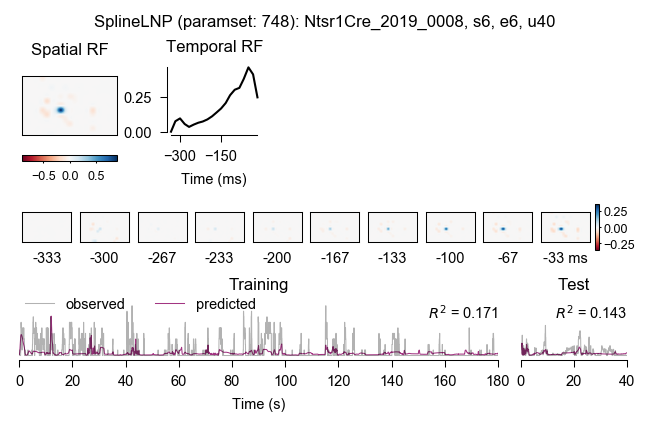

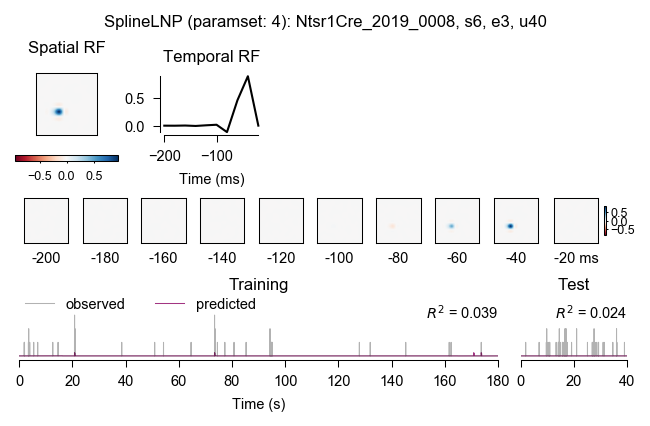

In [70]:
hmov_key = {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 40, 'spl_paramset': 748}
spnoise_key = {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 40, 'spl_paramset': 4}

fig_hm, ax = plot_model(hmov_key, title=True)
fig_sn, ax = plot_model(spnoise_key, title=True)

fig_hm.savefig('./figs/hmov_model.pdf')
fig_sn.savefig('./figs/spnoise_model.pdf')

## Plot model RFs only

In [67]:
def plot_sRF(key, cmap='RdBu', interpolation='spline16', show_ax=False, show_ticks=False, ax=None):

    strf = (SplineLNP() & key).fetch1('spl_w_opt')

    ## Get stRF = model weight vector [time, height=y, width=x]
    # strf = model_out['w_opt']
    sRF, tRF = get_strf_comps(strf)

    # Get max for scaling colormap
    vmax_sRF = np.max(np.abs(sRF))

    # Plot spatial RF
    if ax is None:
        fig, ax = plt.subplots(figsize=cm2inch((4.5, 2.7)), constrained_layout=True)
    else:
        fig = plt.gcf()
    
    im = ax.imshow(sRF, cmap=cmap, interpolation=interpolation, vmin=-vmax_sRF, vmax=vmax_sRF,
                           origin='lower')
    if not show_ax:
        ax.axes.set_axis_off()
    
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    
    cbar = fig.colorbar(im, ax=ax, shrink=0.66)# fraction=0.046, pad=0.04)#, location='bottom', aspect=10, pad=0.0)

In [75]:
fig, ax = plt.subplots(figsize=cm2inch((3.90, 2.34)), constrained_layout=True)
plot_sRF(hmov_key, show_ax=True, show_ticks=False, ax=ax)

fig.savefig('./figs/hmov_model_sRF.pdf')

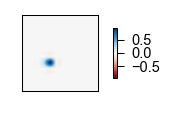

In [77]:
fig, ax = plt.subplots(figsize=cm2inch((2.71, 1.62)), constrained_layout=True)
plot_sRF(spnoise_key, show_ax=True, show_ticks=False, ax=ax)

fig.savefig('./figs/spnoise_model_sRF.pdf')

## Plot Hmov STA

### Plot movie stimulus-corrected STA

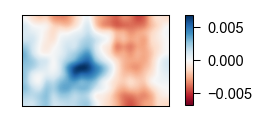

In [76]:
fig, ax = plt.subplots(figsize=cm2inch((4.23, 2.54)), constrained_layout=True)

(HmovUnit() & hmov_key).plot_STA(smooth='spline16', plot_center=False, title=False, show_ax=True, show_ticks=False, ax=ax)

fig.savefig('./figs/hmov_STA_corrected.pdf')

### Plot movie simple STA

In [ ]:
def get_STA(parentkey, stim_correction=True, return_stim=False):
    # STA (spike-triggered average) corrected by mean across movie frames
    # NOTE: From HmovUnit().get_hmu_info_dict()

    movie_array = (Stimulus.HmovScenes() & parentkey).export_scene_seq(scaling=stim_scaling,
                                                                       origin='lower')
    nframes = movie_array.shape[0]
    height = movie_array.shape[1]
    width = movie_array.shape[2]
    X = get_stimulus_design_matrix(movie_array, nlag=1, shift=1)
    X_mean = np.mean(movie_array, 0)

    # Get responses
    tranges, _, _ = (Unit().Spikes() & parentkey).get_tranges()
    spkt_stim = spk_times[
        np.where(np.logical_and(spk_times >= tranges[0][0], spk_times <= tranges[-1][1]))]
    y = np.histogram(spkt_stim, bins=nframes)[0]

    # Get STA analytically
    # Solve for w ( (1/N) * X.T @ y ) and correct by stim mean using the unit vectors
    XtY = X.T @ y
    sta = XtY / len(y)
    sta_reshaped = sta.reshape([height, width])

    # Norm
    sta_norm = sta_reshaped / np.linalg.norm(sta_reshaped)
    X_mean_norm = X_mean / np.linalg.norm(X_mean)

    if stim_correction:
        # Correct STA by mean of stimulus
        sta = sta_corrected = sta_norm - X_mean_norm
    
    if return_stim:
        return sta, X_mean_norm
    else:
        return sta

## CODE SNIPPET

Unit 1/30
hmov key: {'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 9, 'u': 7, 'spl_paramset': 700}
  hmov RF pos (x,y): (12, 8)
  hmov RF QI: 0.497613
  hmov RF area: 58.1599
spnoise key: {'m': 'Ntsr1Cre_2019_0007', 's': 6, 'e': 1, 'u': 7, 'spl_paramset': 4}
  spnoise RF pos (x,y): (8, 8)
  spnoise RF QI: 0.683044
  spnoise RF area: 42.5949


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


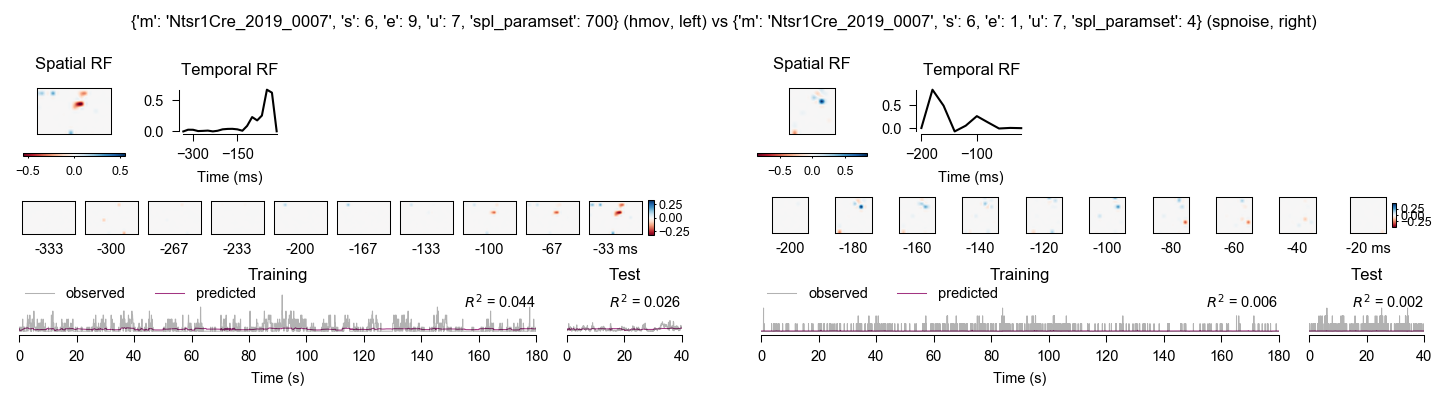

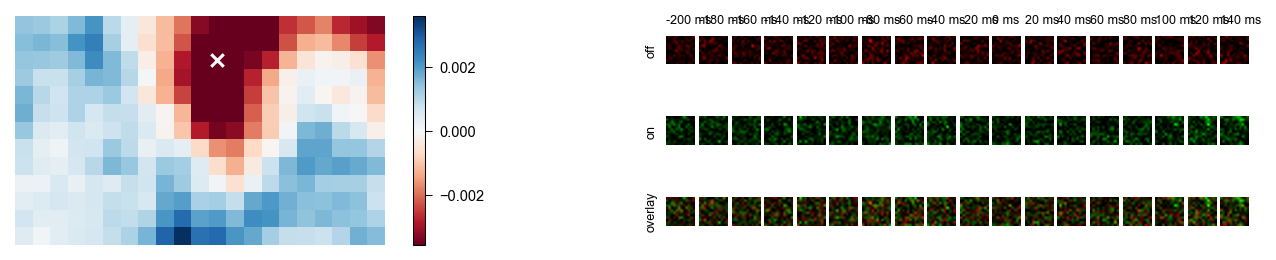

Unit 2/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 25, 'spl_paramset': 796}
  hmov RF pos (x,y): (10, 3)
  hmov RF QI: 0.831591
  hmov RF area: 147.665
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 3, 'u': 25, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 3)
  spnoise RF QI: 0.271769
  spnoise RF area: 15.4397


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


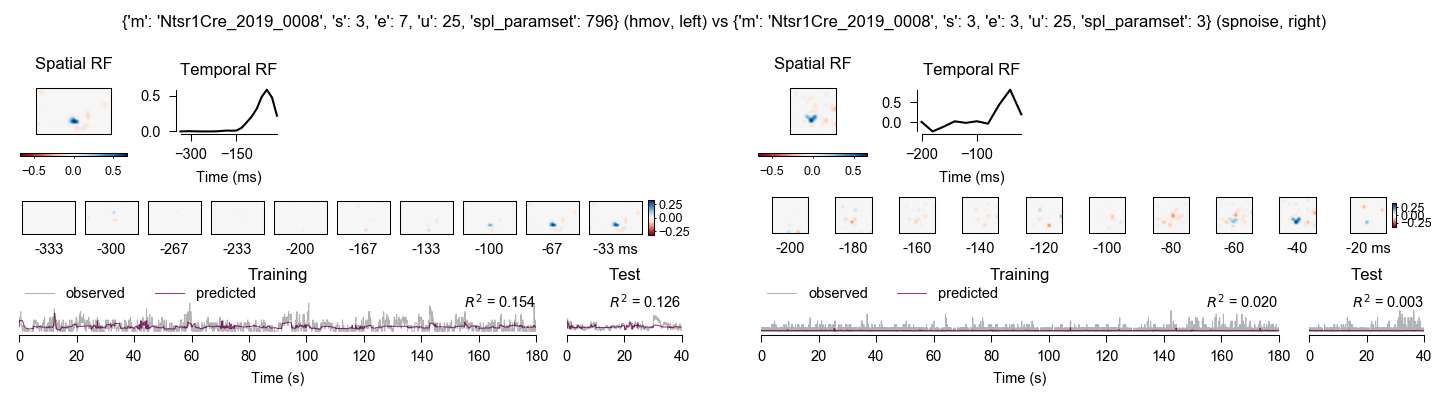

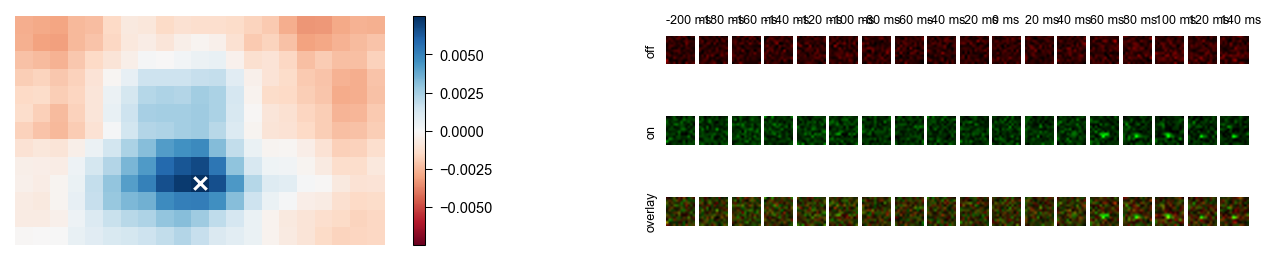

Unit 3/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 7, 'u': 34, 'spl_paramset': 700}
  hmov RF pos (x,y): (12, 2)
  hmov RF QI: 0.814625
  hmov RF area: 80.4311
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 3, 'e': 3, 'u': 34, 'spl_paramset': 3}
  spnoise RF pos (x,y): (8, 2)
  spnoise RF QI: 0.802406
  spnoise RF area: 90.2928


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


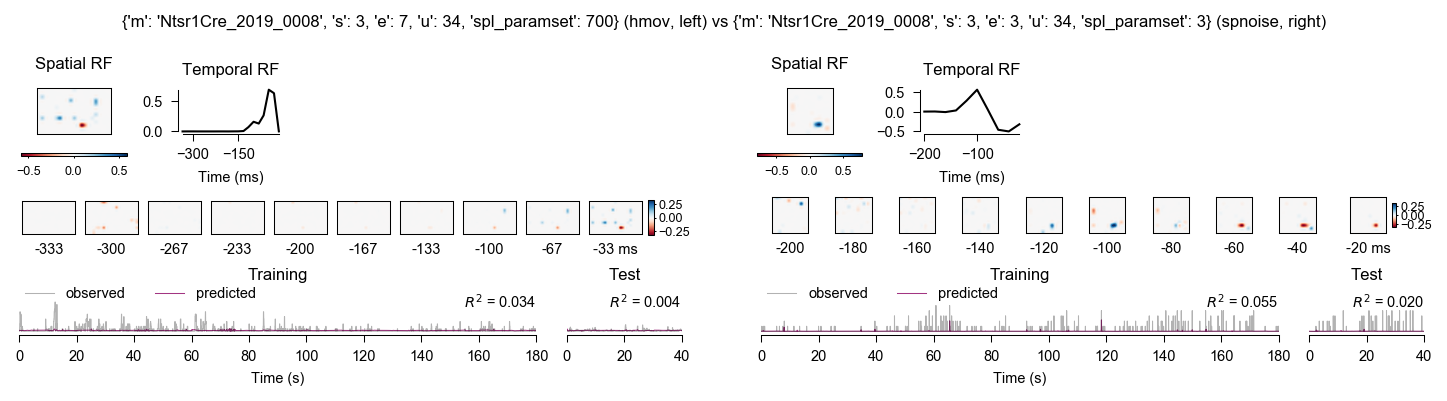

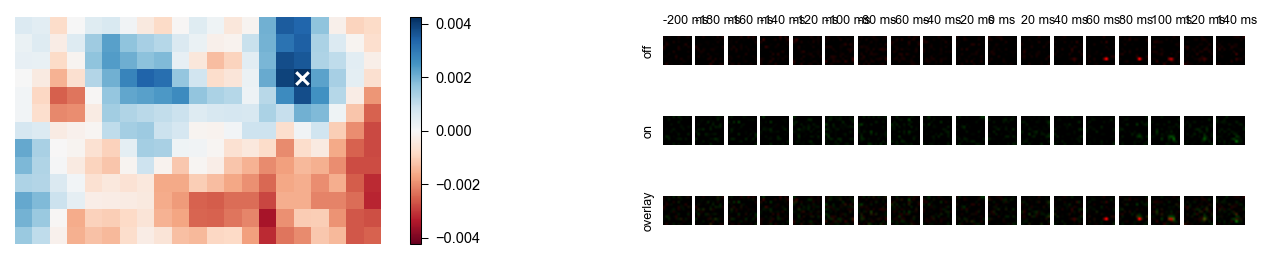

Unit 4/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 8, 'u': 19, 'spl_paramset': 796}
  hmov RF pos (x,y): (10, 7)
  hmov RF QI: 0.839981
  hmov RF area: 133.844
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 5, 'e': 3, 'u': 19, 'spl_paramset': 4}
  spnoise RF pos (x,y): (5, 7)
  spnoise RF QI: 0.825978
  spnoise RF area: 60.3906


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


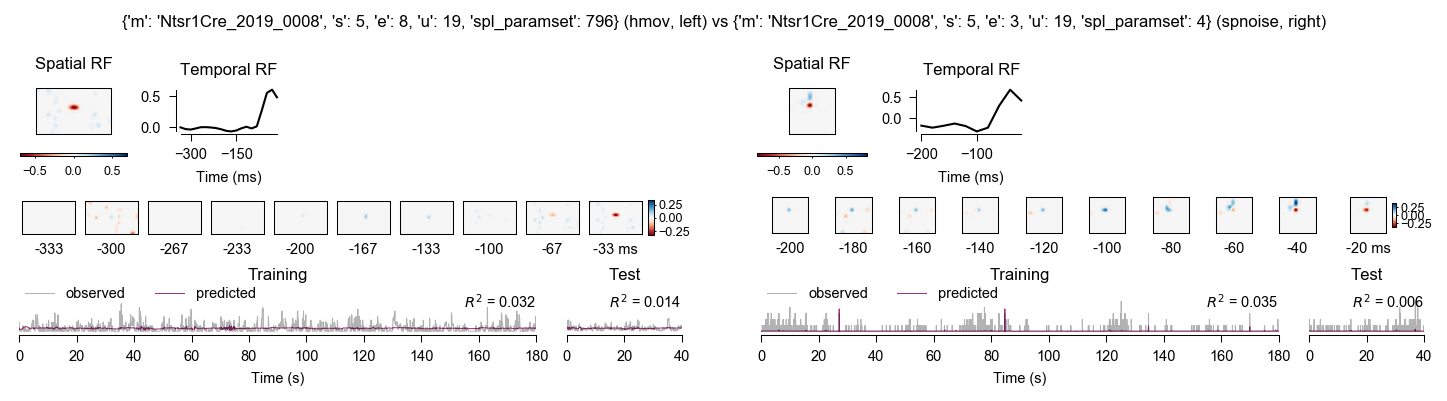

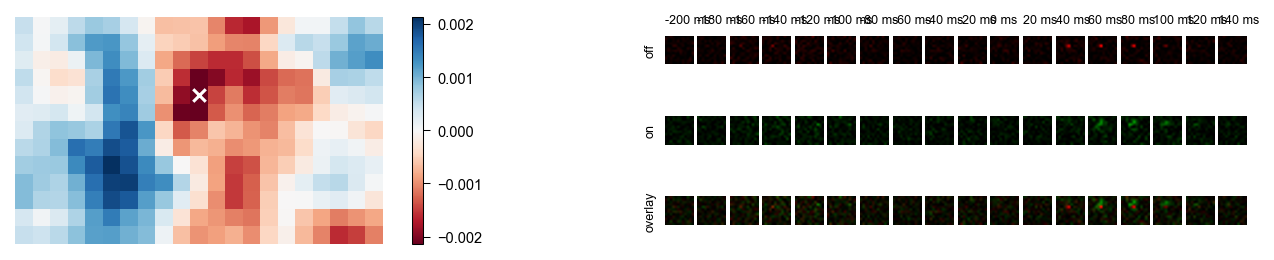

Unit 5/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 30, 'spl_paramset': 700}
  hmov RF pos (x,y): (7, 7)
  hmov RF QI: 0.889586
  hmov RF area: 82.8853
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 30, 'spl_paramset': 4}
  spnoise RF pos (x,y): (3, 6)
  spnoise RF QI: 0.820052
  spnoise RF area: 96.0582


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


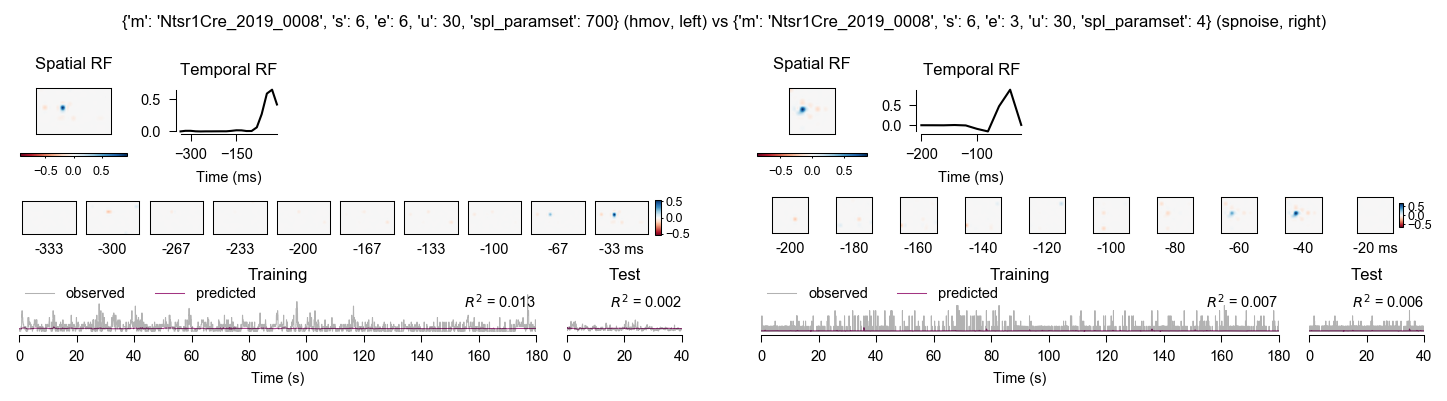

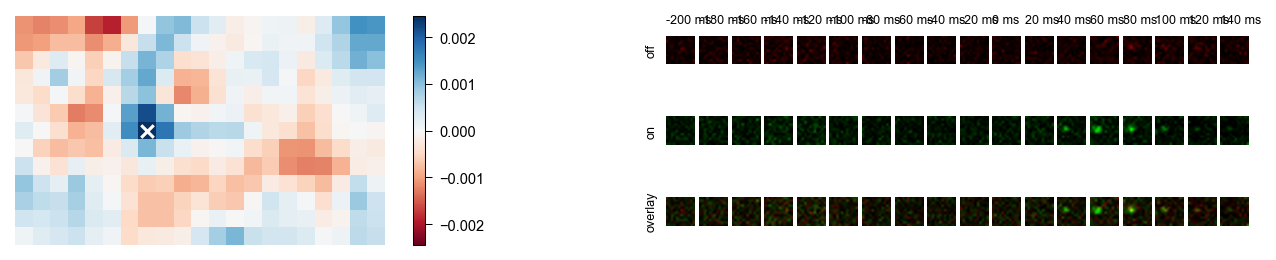

Unit 6/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 40, 'spl_paramset': 748}
  hmov RF pos (x,y): (8, 5)
  hmov RF QI: 0.883153
  hmov RF area: 87.9906
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 40, 'spl_paramset': 4}
  spnoise RF pos (x,y): (4, 4)
  spnoise RF QI: 0.844142
  spnoise RF area: 71.1398


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


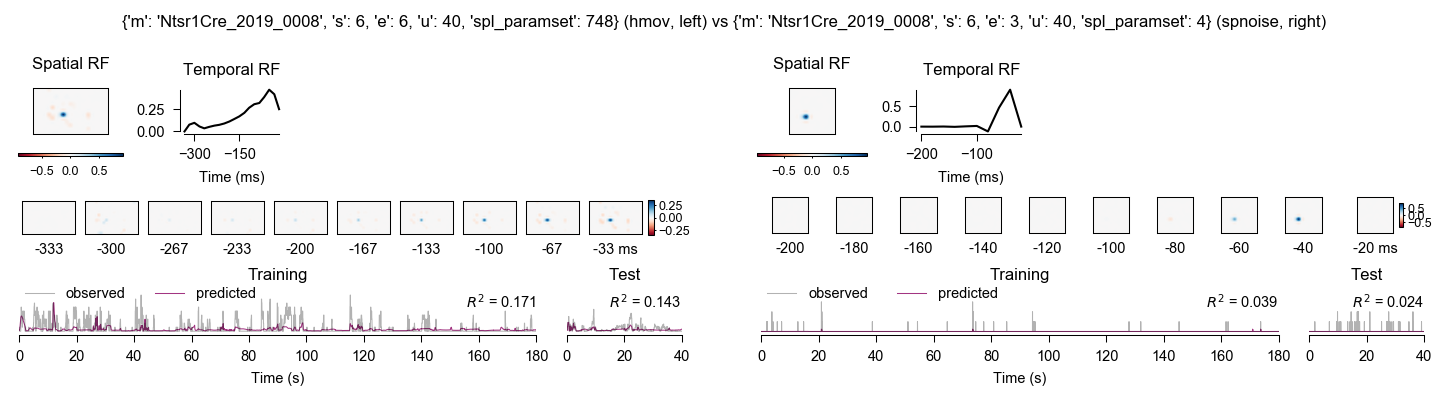

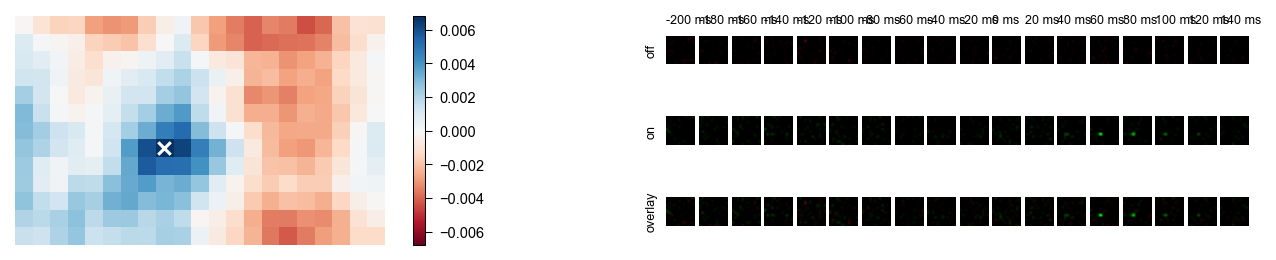

Unit 7/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 6, 'u': 46, 'spl_paramset': 796}
  hmov RF pos (x,y): (8, 5)
  hmov RF QI: 0.812102
  hmov RF area: 138.042
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 6, 'e': 3, 'u': 46, 'spl_paramset': 4}
  spnoise RF pos (x,y): (4, 4)
  spnoise RF QI: 0.774406
  spnoise RF area: 99.283


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


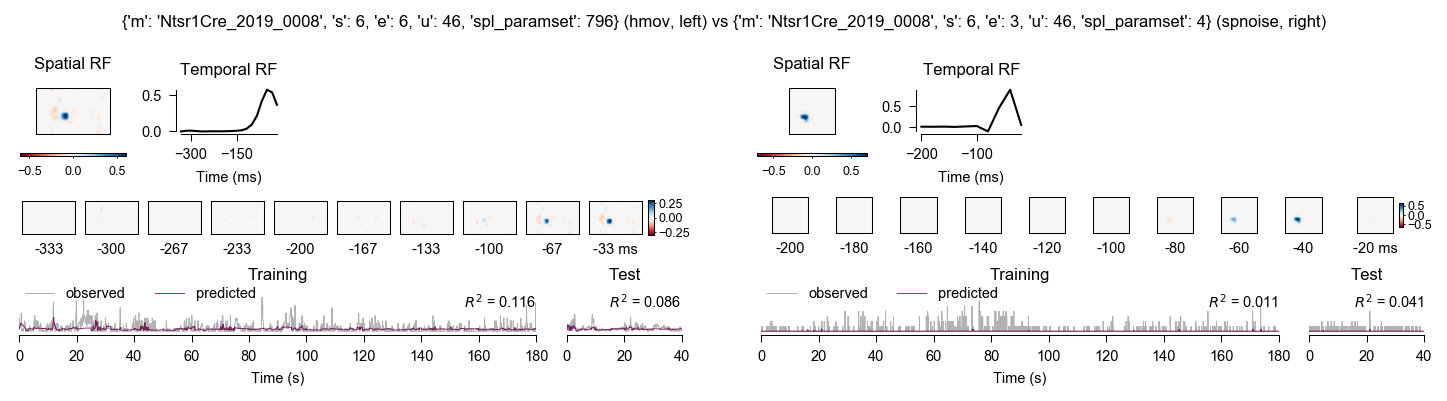

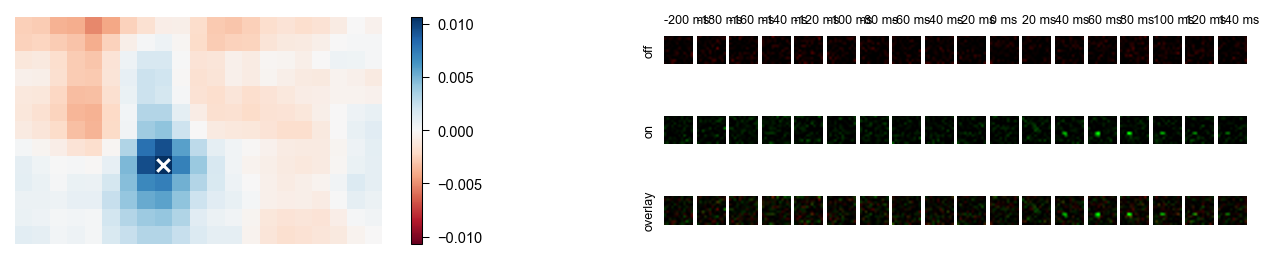

Unit 8/30
hmov key: {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 6, 'u': 6, 'spl_paramset': 700}
  hmov RF pos (x,y): (9, 7)
  hmov RF QI: 0.875661
  hmov RF area: 101.004
spnoise key: {'m': 'Ntsr1Cre_2019_0008', 's': 7, 'e': 3, 'u': 6, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 6)
  spnoise RF QI: 0.779182
  spnoise RF area: 90.6836


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


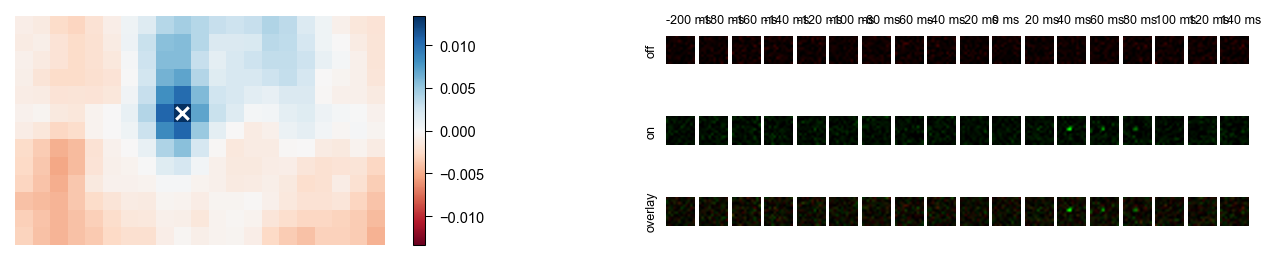

Unit 9/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 6, 'u': 4, 'spl_paramset': 796}
  hmov RF pos (x,y): (9, 6)
  hmov RF QI: 0.810366
  hmov RF area: 164.77
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 1, 'u': 4, 'spl_paramset': 4}
  spnoise RF pos (x,y): (2, 7)
  spnoise RF QI: 0.323299
  spnoise RF area: 42.0194


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


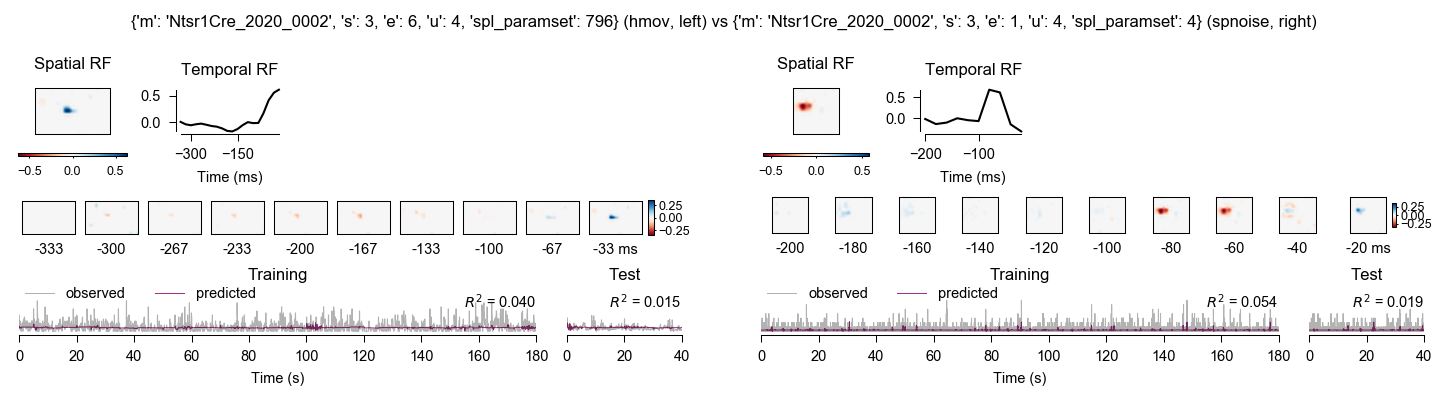

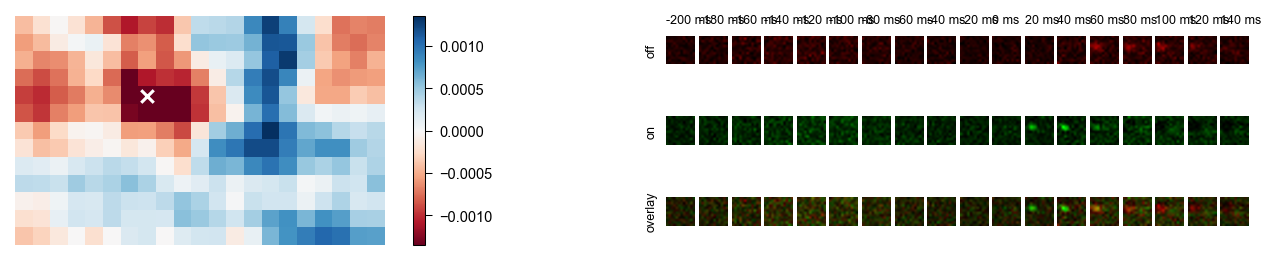

Unit 10/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 6, 'u': 15, 'spl_paramset': 748}
  hmov RF pos (x,y): (9, 4)
  hmov RF QI: 0.831002
  hmov RF area: 113.817
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 1, 'u': 15, 'spl_paramset': 3}
  spnoise RF pos (x,y): (3, 4)
  spnoise RF QI: 0.683892
  spnoise RF area: 117.556


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


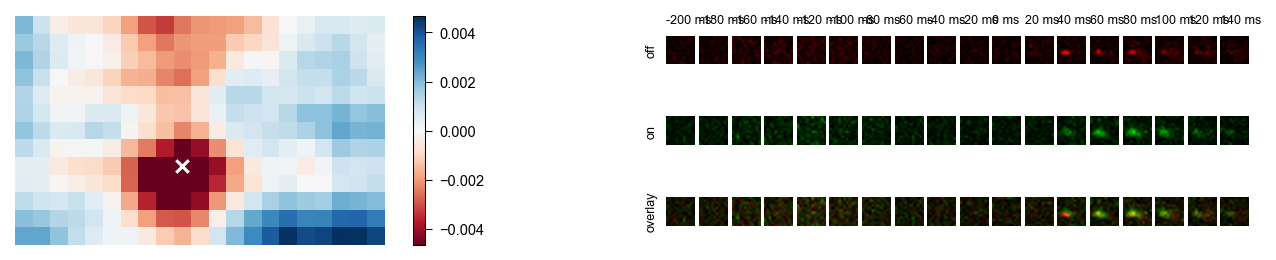

Unit 11/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 6, 'u': 20, 'spl_paramset': 700}
  hmov RF pos (x,y): (11, 2)
  hmov RF QI: 0.828546
  hmov RF area: 96.3992
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 3, 'e': 1, 'u': 20, 'spl_paramset': 3}
  spnoise RF pos (x,y): (4, 4)
  spnoise RF QI: 0.643744
  spnoise RF area: 47.5894


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Unit 12/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 6, 'u': 14, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 7)
  hmov RF QI: 0.278811
  hmov RF area: 17.9184
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 1, 'u': 14, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 7)
  spnoise RF QI: 0.665042
  spnoise RF area: 71.6283


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


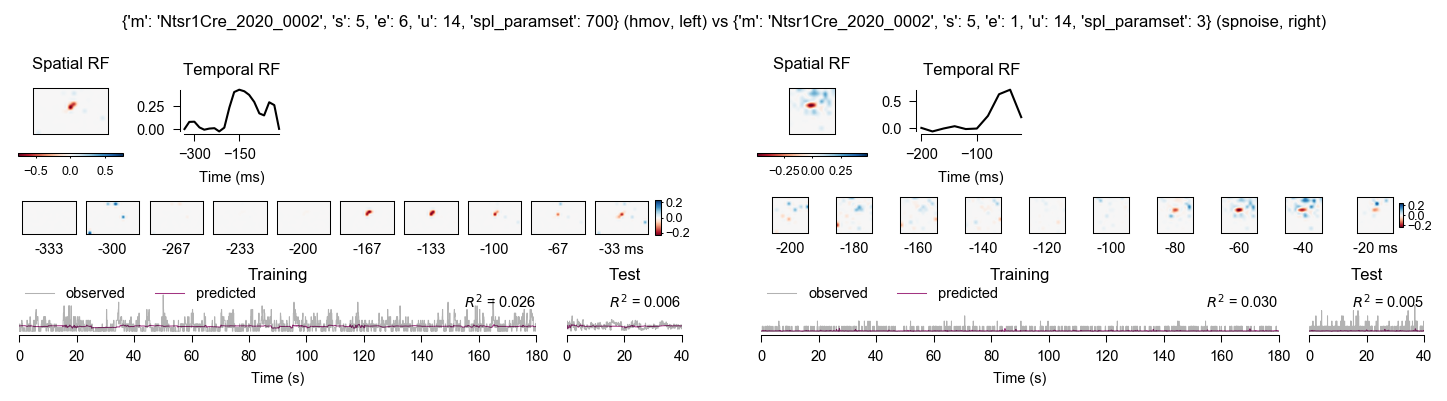

Unit 13/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 6, 'u': 39, 'spl_paramset': 700}
  hmov RF pos (x,y): (11, 4)
  hmov RF QI: 0.852768
  hmov RF area: 122.326
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 1, 'u': 39, 'spl_paramset': 3}
  spnoise RF pos (x,y): (8, 4)
  spnoise RF QI: 0.403442
  spnoise RF area: 19.837


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


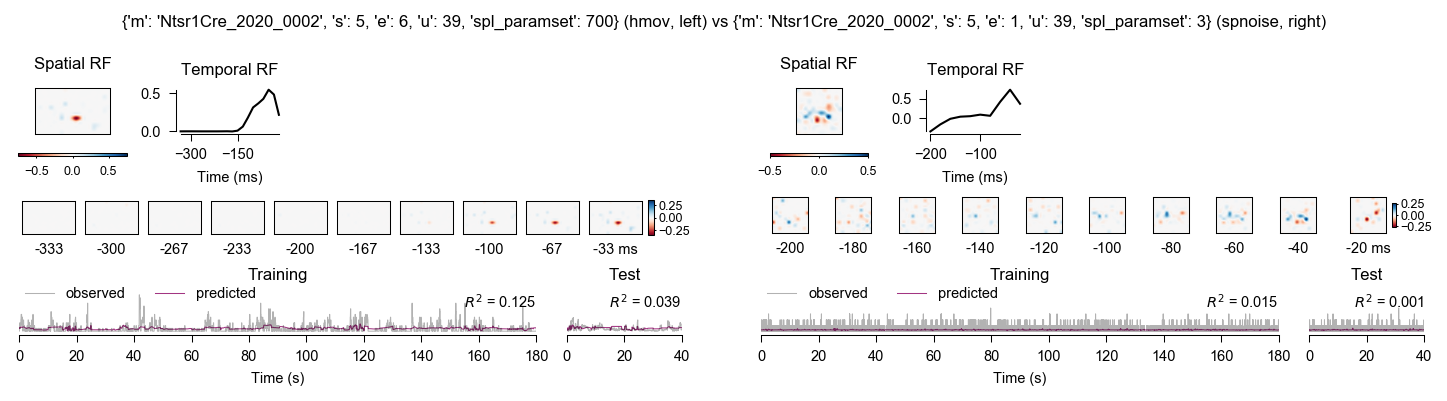

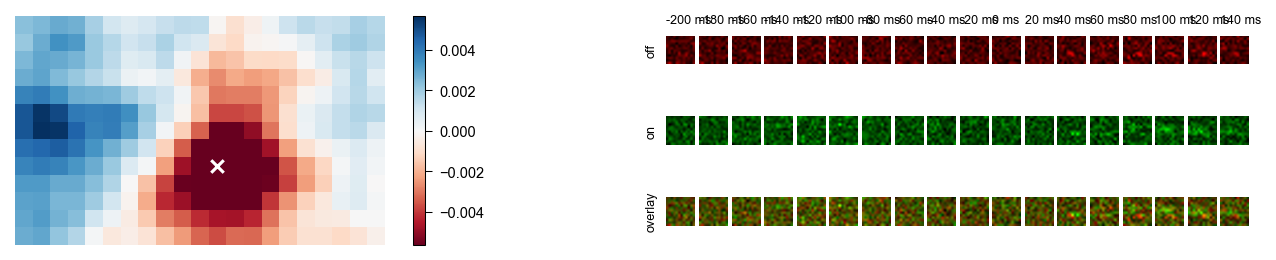

Unit 14/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 6, 'u': 56, 'spl_paramset': 700}
  hmov RF pos (x,y): (13, 2)
  hmov RF QI: 0.646399
  hmov RF area: 105.509
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 5, 'e': 1, 'u': 56, 'spl_paramset': 3}
  spnoise RF pos (x,y): (6, 2)
  spnoise RF QI: 0.711256
  spnoise RF area: 144.429


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


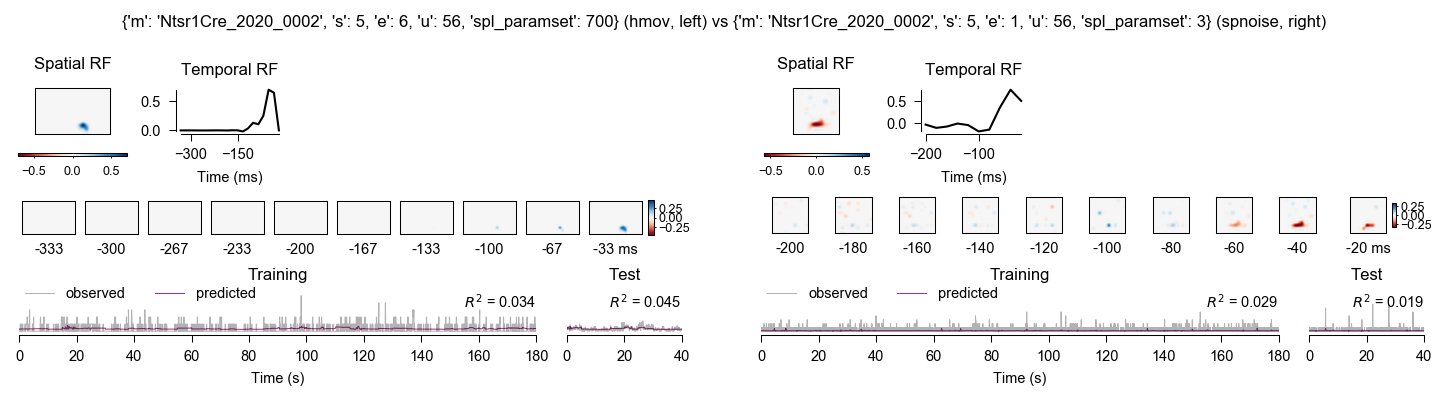

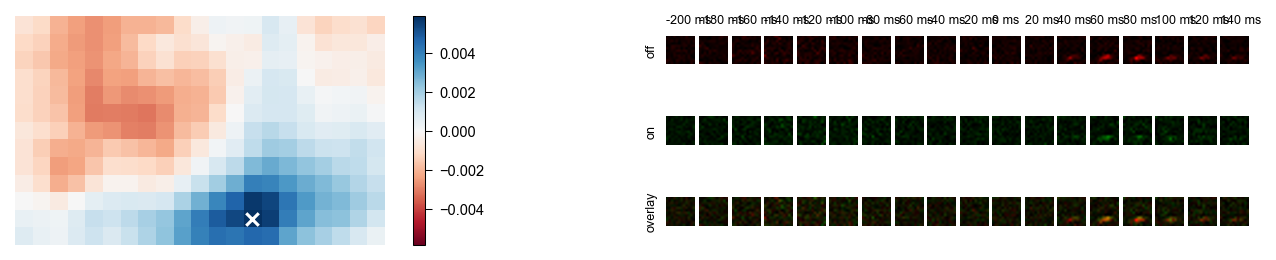

Unit 15/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 6, 'u': 9, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 6)
  hmov RF QI: 0.825705
  hmov RF area: 139.744
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 1, 'u': 9, 'spl_paramset': 3}
  spnoise RF pos (x,y): (4, 6)
  spnoise RF QI: 0.582666
  spnoise RF area: 81.7912


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Unit 16/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 6, 'u': 15, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 5)
  hmov RF QI: 0.823846
  hmov RF area: 130.935
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 1, 'u': 15, 'spl_paramset': 3}
  spnoise RF pos (x,y): (3, 5)
  spnoise RF QI: 0.235389
  spnoise RF area: 15.7328


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Unit 17/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 6, 'u': 17, 'spl_paramset': 796}
  hmov RF pos (x,y): (11, 4)
  hmov RF QI: 0.707681
  hmov RF area: 70.1722
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 1, 'u': 17, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 4)
  spnoise RF QI: 0.398418
  spnoise RF area: 44.6578


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


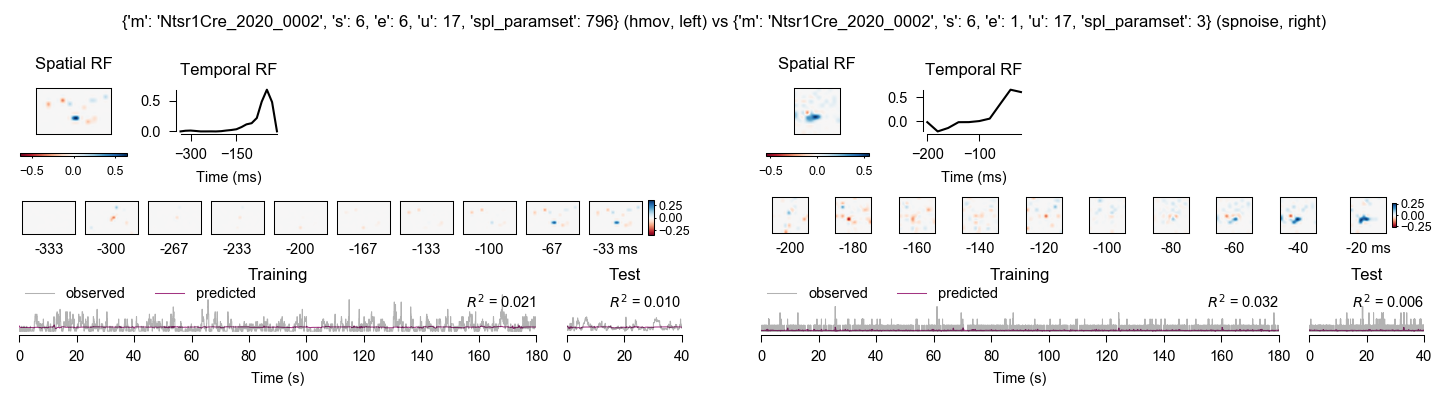

Unit 18/30
hmov key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 6, 'u': 18, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 2)
  hmov RF QI: 0.730254
  hmov RF area: 108.311
spnoise key: {'m': 'Ntsr1Cre_2020_0002', 's': 6, 'e': 1, 'u': 18, 'spl_paramset': 3}
  spnoise RF pos (x,y): (4, 2)
  spnoise RF QI: 0.364539
  spnoise RF area: 108.273


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


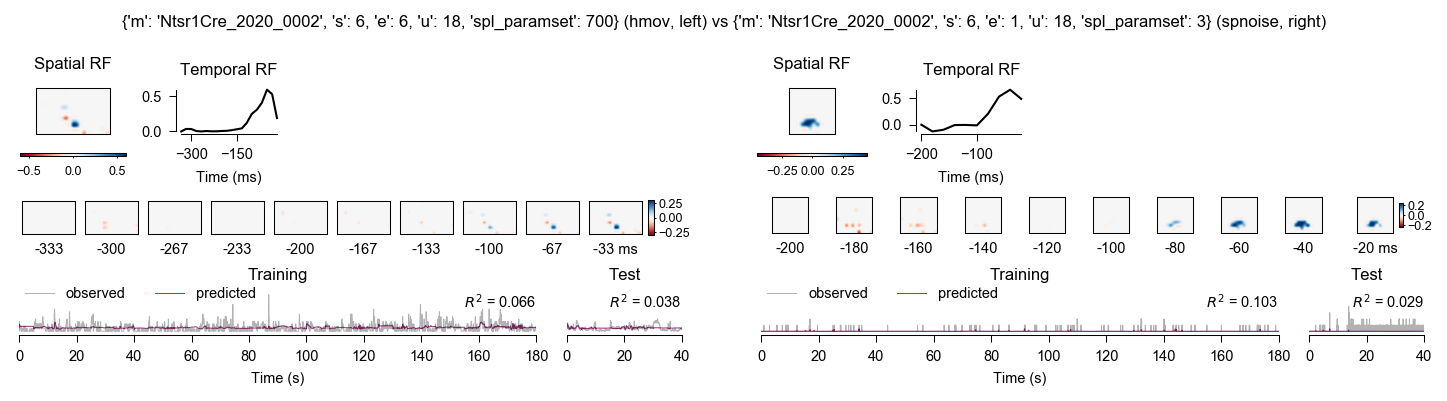

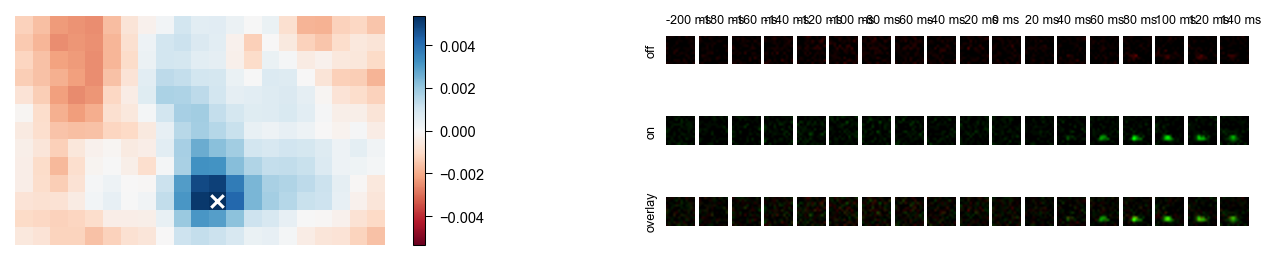

Unit 19/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 17, 'spl_paramset': 700}
  hmov RF pos (x,y): (9, 4)
  hmov RF QI: 0.81906
  hmov RF area: 91.5943
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 17, 'spl_paramset': 3}
  spnoise RF pos (x,y): (6, 4)
  spnoise RF QI: 0.665432
  spnoise RF area: 177.068
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 17}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


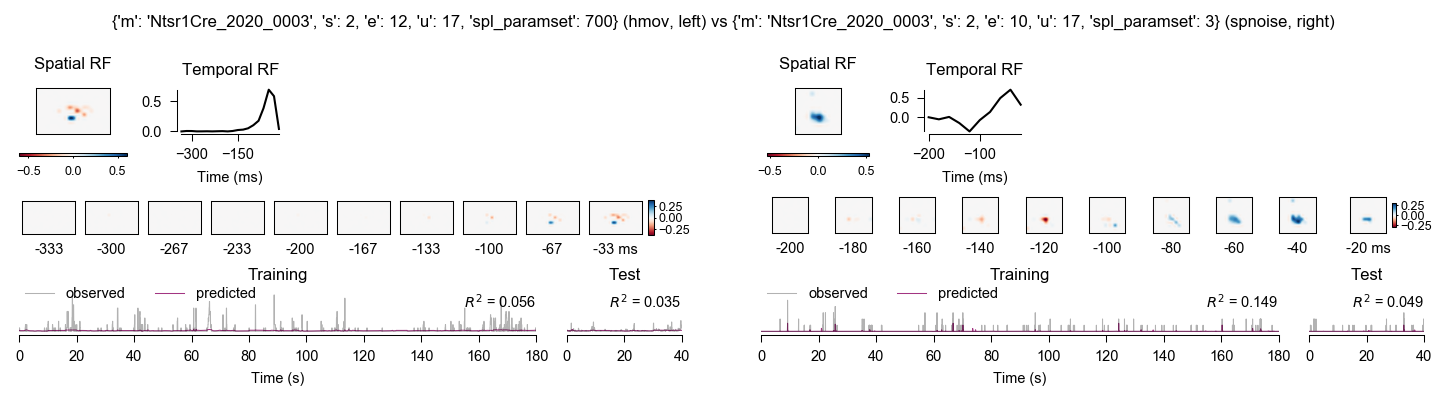

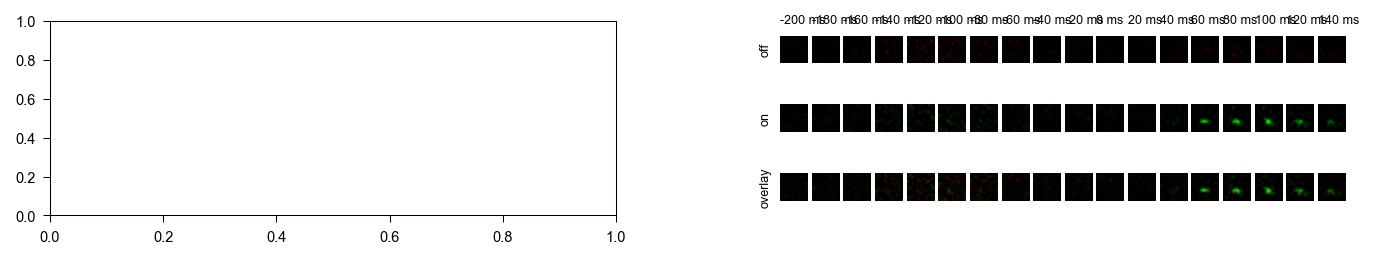

Unit 20/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 29, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 5)
  hmov RF QI: 0.775544
  hmov RF area: 118.522
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 29, 'spl_paramset': 4}
  spnoise RF pos (x,y): (5, 5)
  spnoise RF QI: 0.755022
  spnoise RF area: 108.371
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 29}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


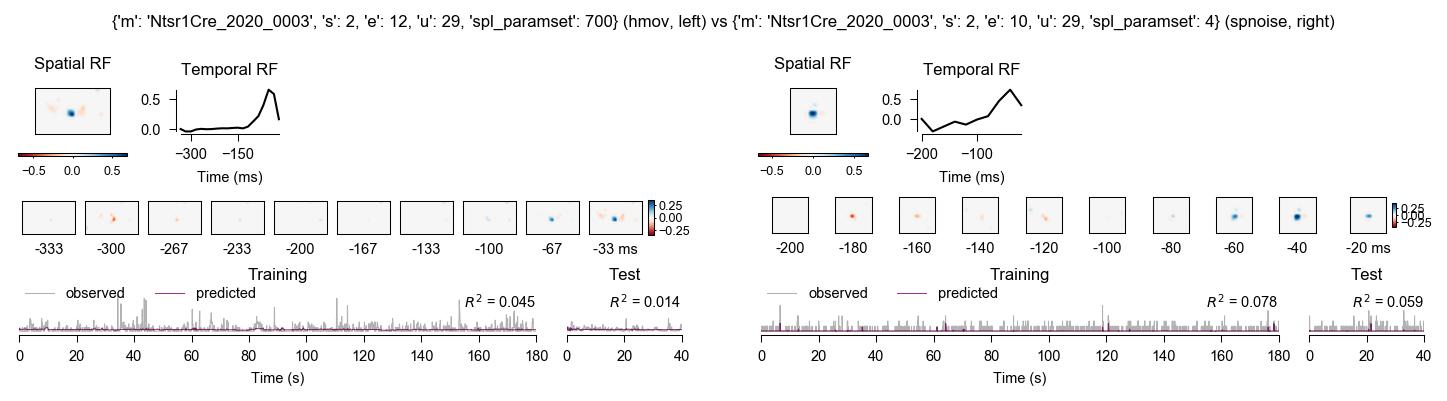

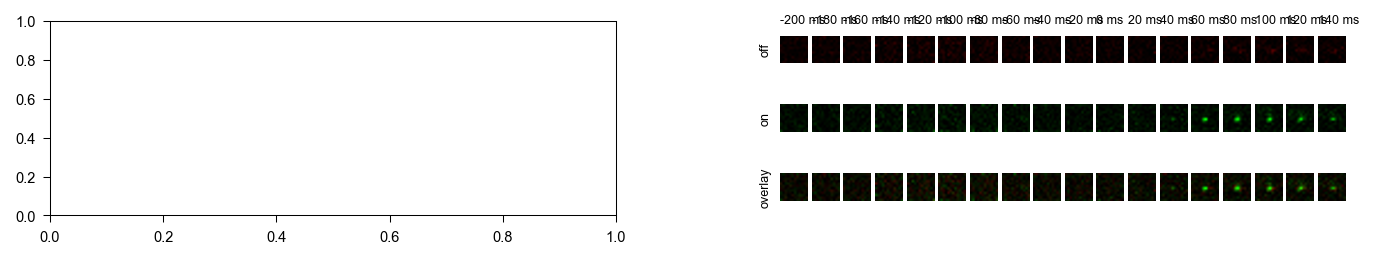

Unit 21/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 34, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 6)
  hmov RF QI: 0.896302
  hmov RF area: 69.4715
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 34, 'spl_paramset': 4}
  spnoise RF pos (x,y): (2, 7)
  spnoise RF QI: 0.683832
  spnoise RF area: 146.579
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 34}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


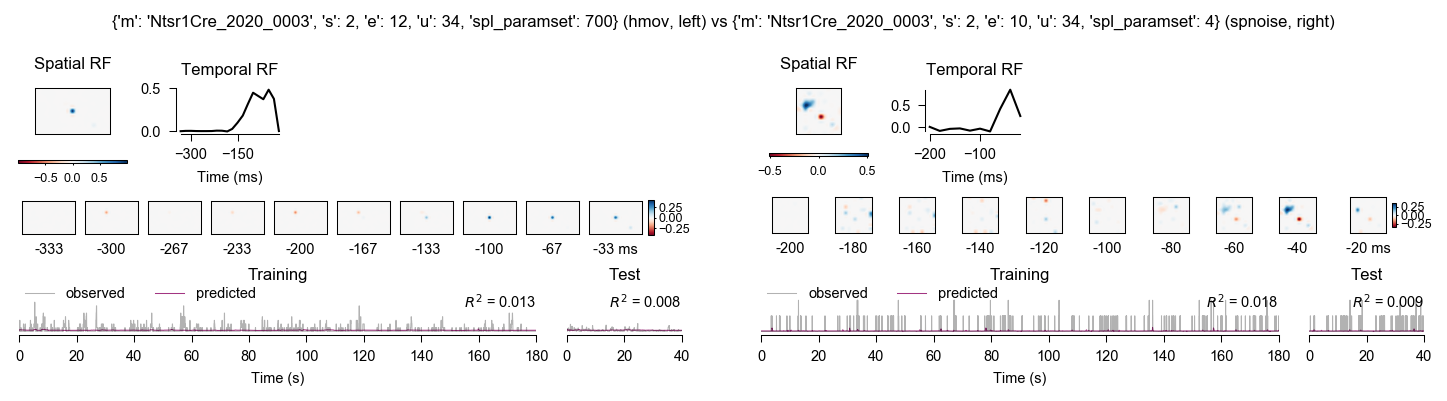

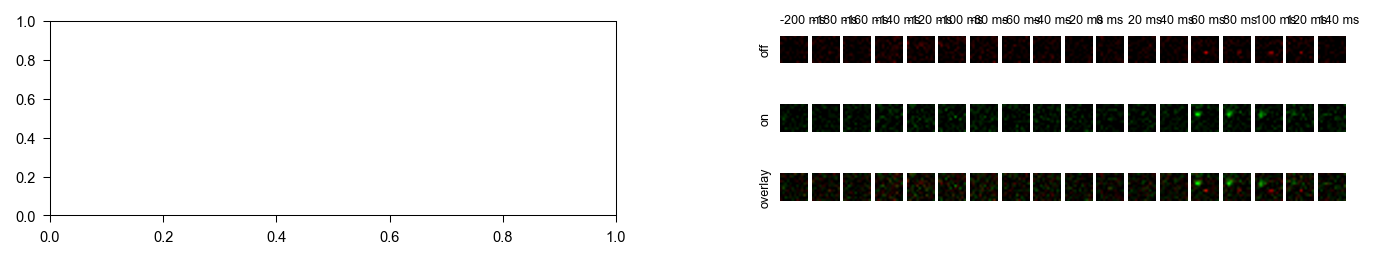

Unit 22/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 35, 'spl_paramset': 700}
  hmov RF pos (x,y): (11, 6)
  hmov RF QI: 0.871768
  hmov RF area: 90.8935
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 35, 'spl_paramset': 4}
  spnoise RF pos (x,y): (5, 4)
  spnoise RF QI: 0.355201
  spnoise RF area: 125.765
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 35}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


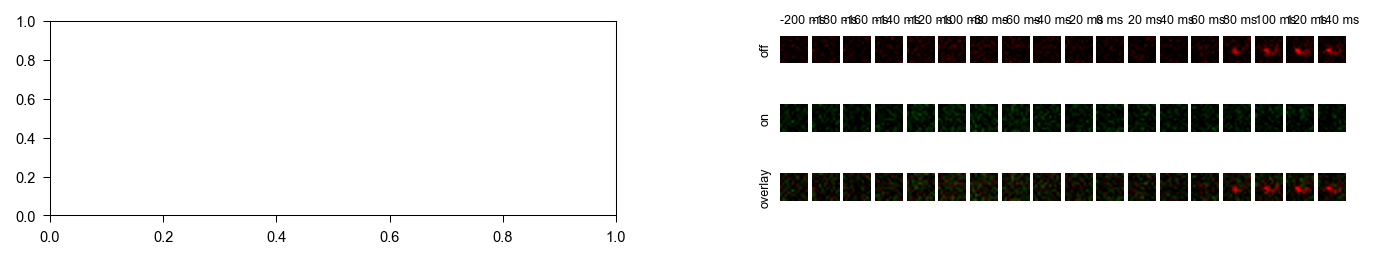

Unit 23/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 37, 'spl_paramset': 700}
  hmov RF pos (x,y): (10, 5)
  hmov RF QI: 0.883059
  hmov RF area: 89.9926
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 37, 'spl_paramset': 4}
  spnoise RF pos (x,y): (5, 5)
  spnoise RF QI: 0.779082
  spnoise RF area: 65.6675
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 37}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


Unit 24/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 45, 'spl_paramset': 700}
  hmov RF pos (x,y): (12, 6)
  hmov RF QI: 0.808017
  hmov RF area: 152.357
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 45, 'spl_paramset': 4}
  spnoise RF pos (x,y): (5, 5)
  spnoise RF QI: 0.648929
  spnoise RF area: 200.813
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 45}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


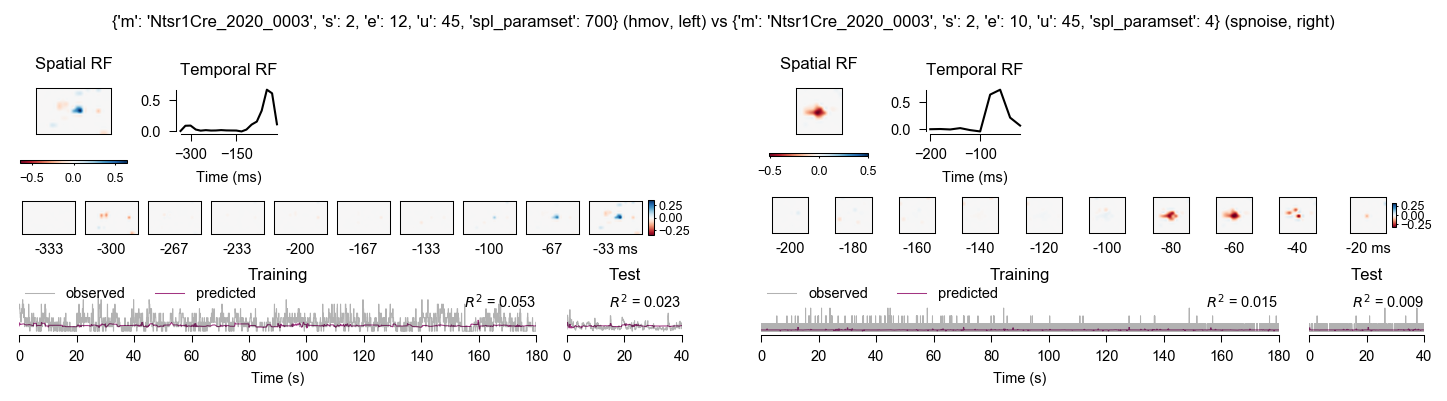

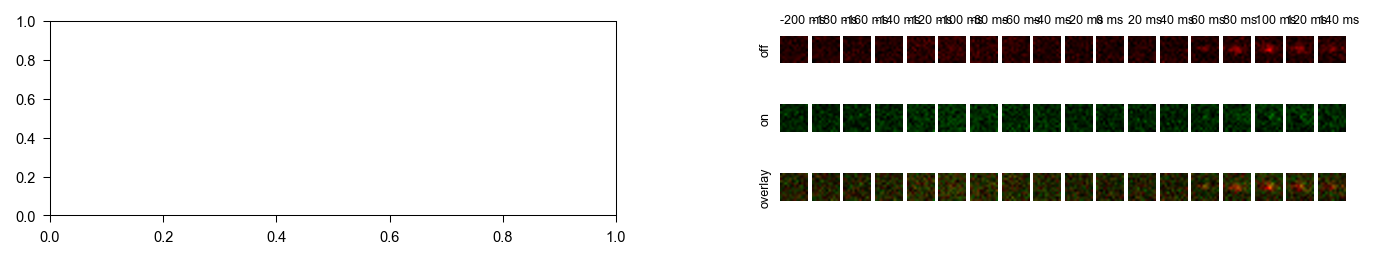

Unit 25/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 51, 'spl_paramset': 700}
  hmov RF pos (x,y): (14, 9)
  hmov RF QI: 0.454655
  hmov RF area: 23.6243
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 51, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 7)
  spnoise RF QI: 0.36511
  spnoise RF area: 30.3907
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 51}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


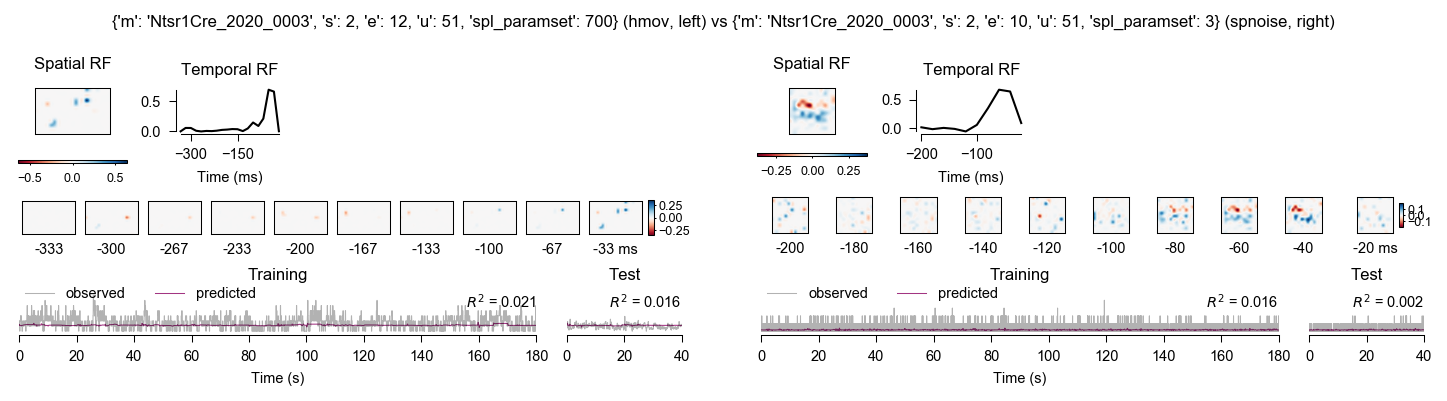

Unit 26/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 58, 'spl_paramset': 700}
  hmov RF pos (x,y): (8, 5)
  hmov RF QI: 0.789375
  hmov RF area: 63.6655
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 58, 'spl_paramset': 4}
  spnoise RF pos (x,y): (8, 5)
  spnoise RF QI: 0.218859
  spnoise RF area: 8.59931
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 58}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


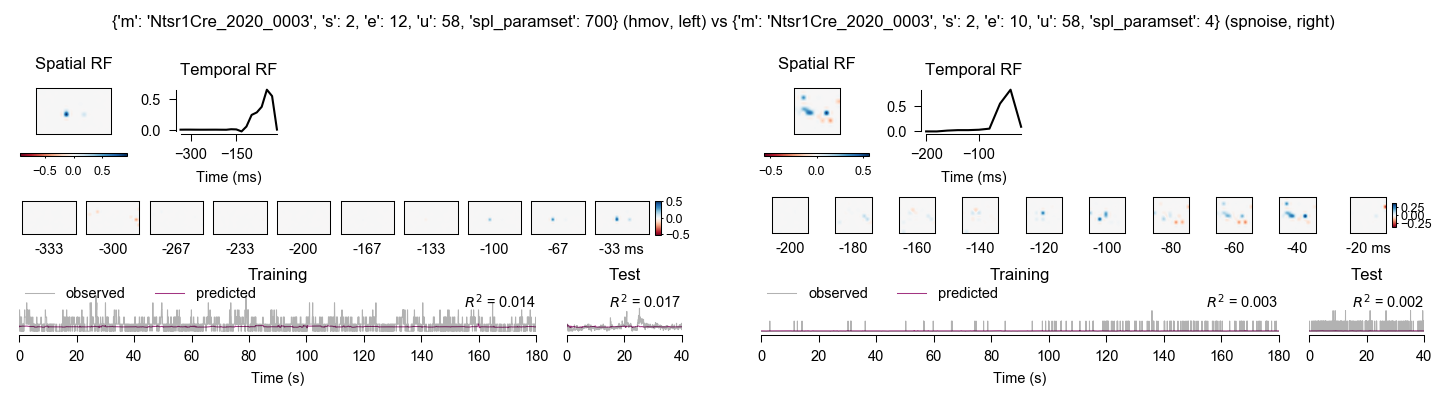

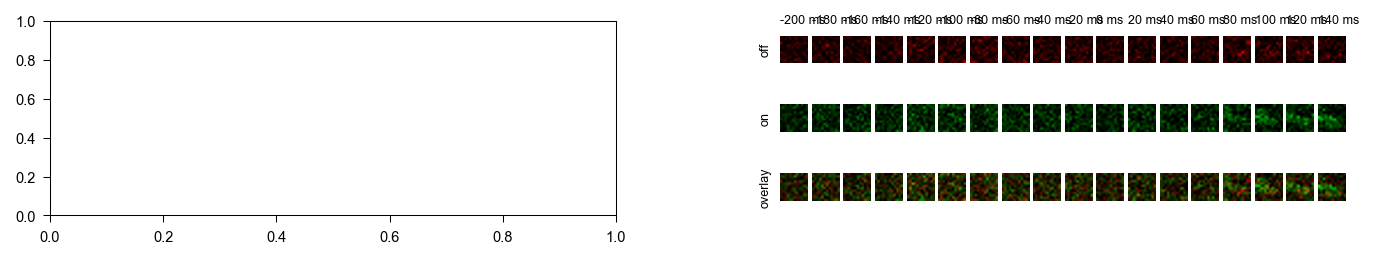

Unit 27/30
hmov key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 77, 'spl_paramset': 700}
  hmov RF pos (x,y): (9, 6)
  hmov RF QI: 0.226221
  hmov RF area: 15.4159
spnoise key: {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 10, 'u': 77, 'spl_paramset': 4}
  spnoise RF pos (x,y): (7, 5)
  spnoise RF QI: 0.624466
  spnoise RF area: 122.442
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0003', 's': 2, 'e': 12, 'u': 77}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


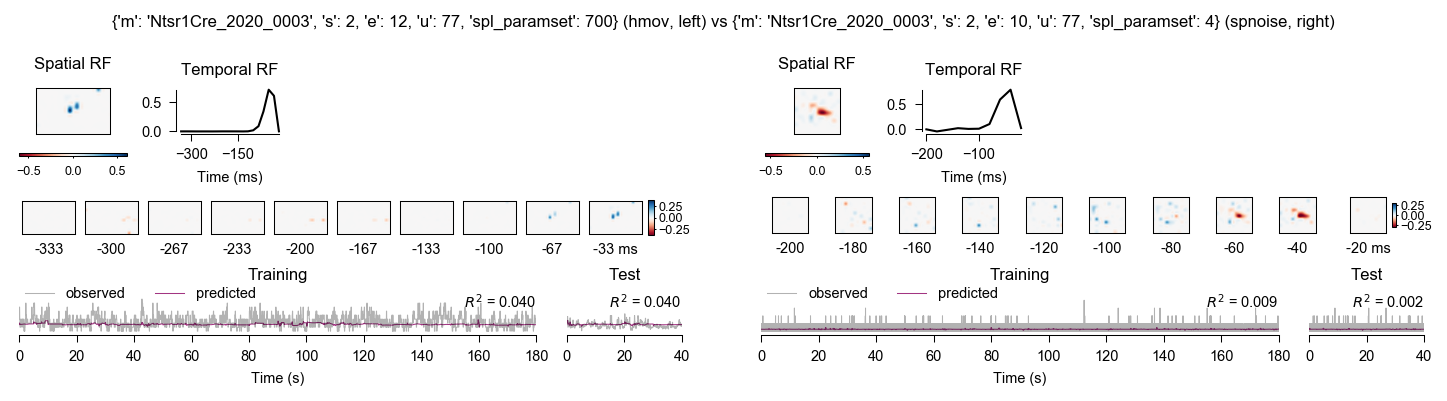

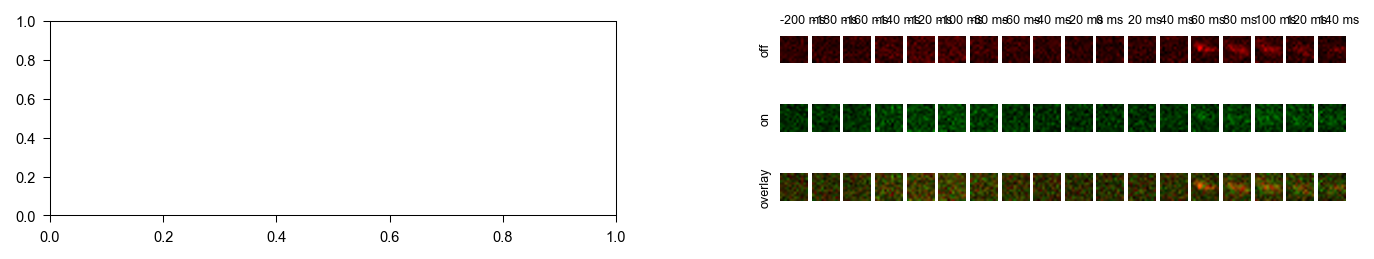

Unit 28/30
hmov key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 3, 'spl_paramset': 700}
  hmov RF pos (x,y): (7, 4)
  hmov RF QI: 0.412858
  hmov RF area: 18.6192
spnoise key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 9, 'u': 3, 'spl_paramset': 3}
  spnoise RF pos (x,y): (4, 6)
  spnoise RF QI: 0.6444
  spnoise RF area: 74.5599
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 3}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


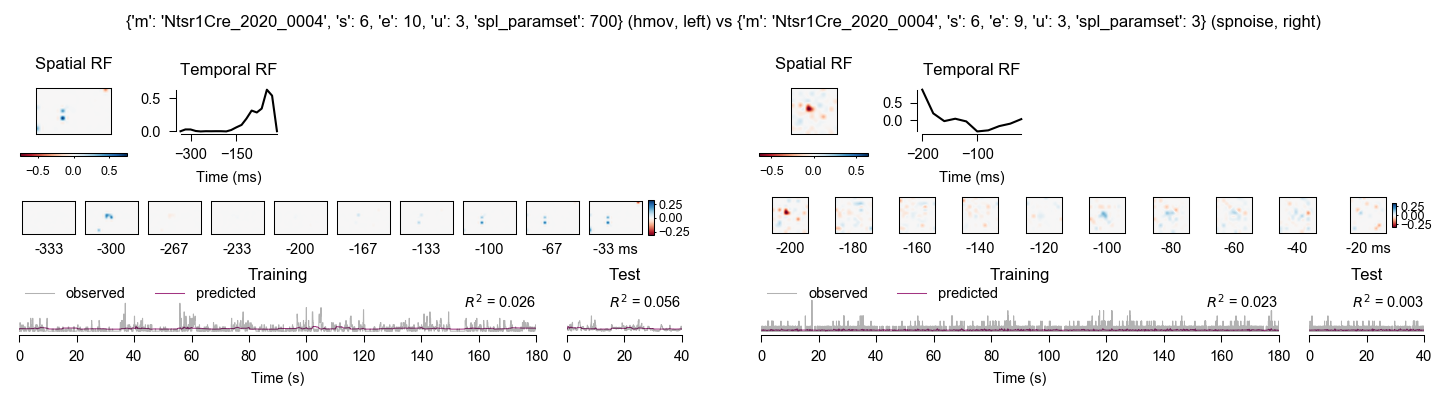

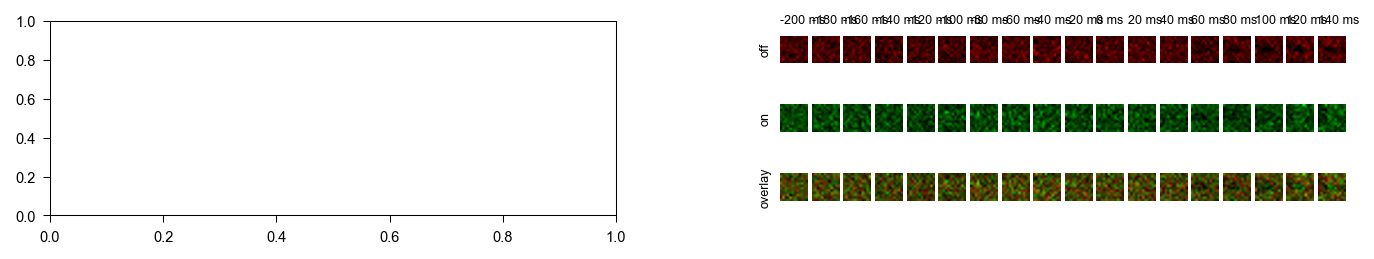

Unit 29/30
hmov key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 5, 'spl_paramset': 700}
  hmov RF pos (x,y): (9, 5)
  hmov RF QI: 0.767996
  hmov RF area: 48.3498
spnoise key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 9, 'u': 5, 'spl_paramset': 3}
  spnoise RF pos (x,y): (5, 5)
  spnoise RF QI: 0.709587
  spnoise RF area: 142.28
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 5}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


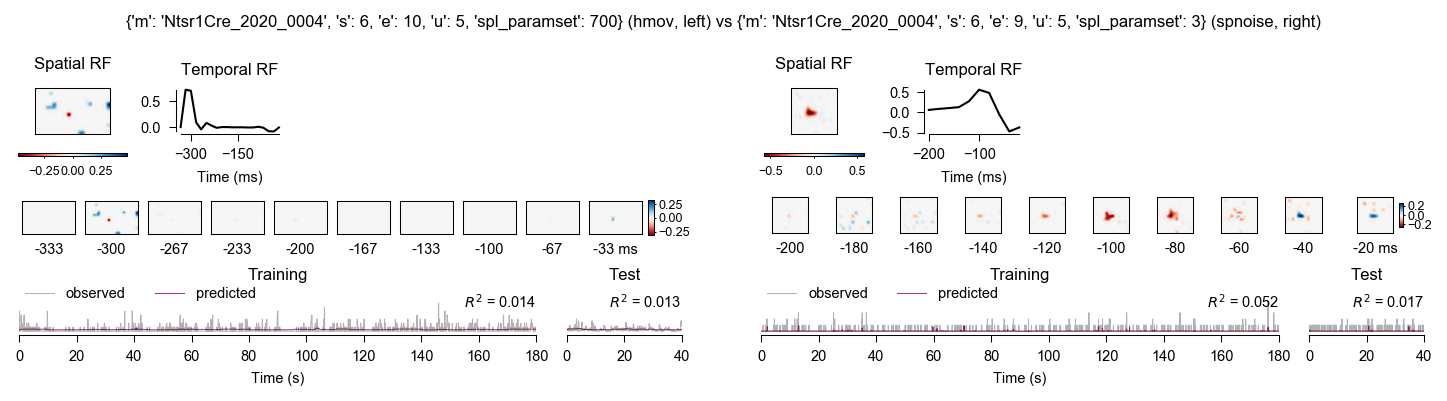

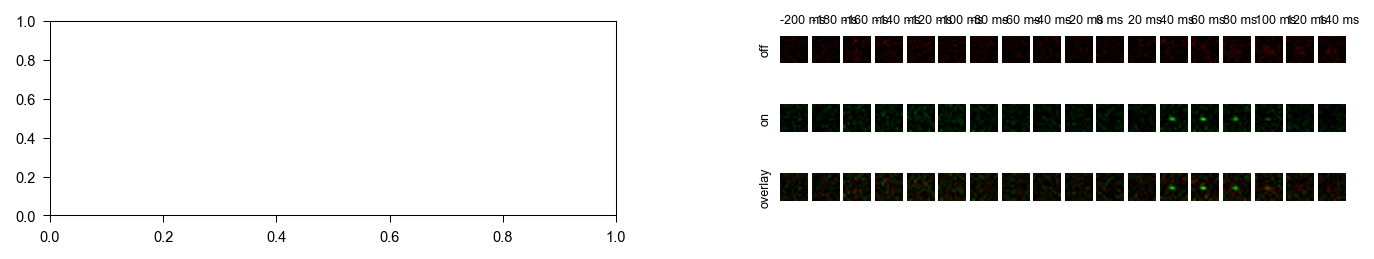

Unit 30/30
hmov key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 9, 'spl_paramset': 700}
  hmov RF pos (x,y): (11, 5)
  hmov RF QI: 0.447523
  hmov RF area: 26.227
spnoise key: {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 9, 'u': 9, 'spl_paramset': 4}
  spnoise RF pos (x,y): (4, 4)
  spnoise RF QI: 0.848249
  spnoise RF area: 62.7359
No Hmov-stimTA for {'m': 'Ntsr1Cre_2020_0004', 's': 6, 'e': 10, 'u': 9}.


/Users/ybauer/code/djd/djd/unit.py:1752: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


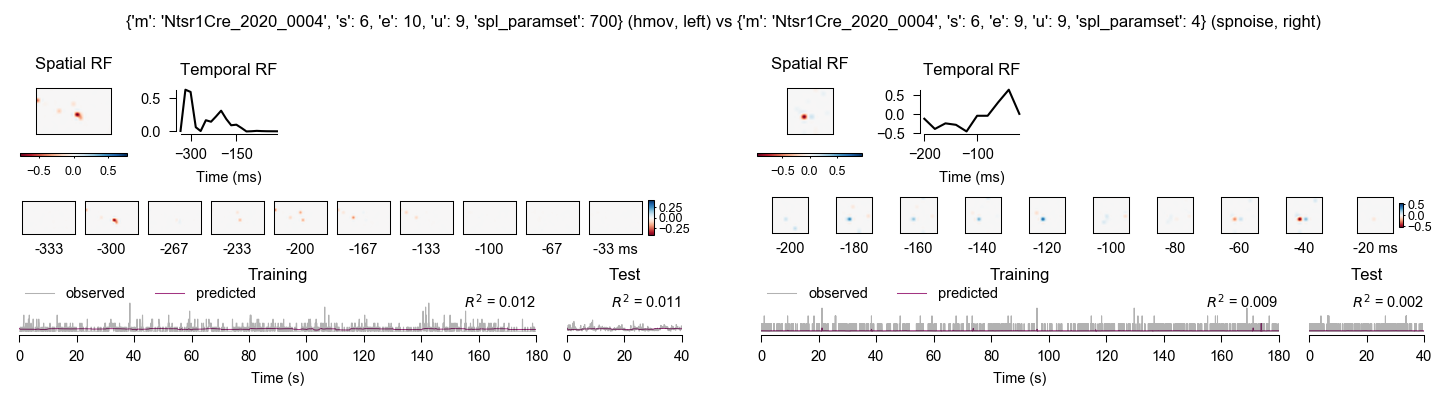

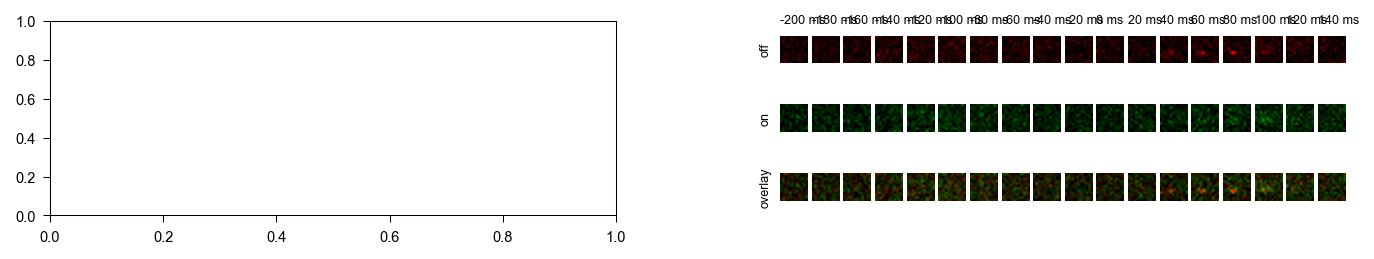

In [32]:
# Copy df to units df
units = df.copy()

## Plot paired hmov vs spnoise model per unit
for i, unit in units.iterrows():
    print(f"Unit {i+1}/{len(units)}")
    
    # Initialize figure (per unit)
    fig = plt.figure(figsize=cm2inch((24, 6.5)), dpi=150, constrained_layout=True)  # need to set constrained layout here!
#     fig = plt.figure(figsize=cm2inch((24, 10)), dpi=150, constrained_layout=True)  # need to set constrained layout here!
    gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1, 0.1, 1])  # 2nd column just for subfig spacing

    # Plot hmov model
    try:
        key1 = {'m': unit.m, 's': unit.s, 'e': unit.e_x, 'u': unit.u, 'spl_paramset': unit.paramset_x}
        fig, axs = plot_model(key1, title=False, gs=gs[0])
        print(f'hmov key: {key1}')
        print(f'  hmov RF pos (x,y): ({unit.rf_x_pos_pix_x}, {unit.rf_y_pos_pix_x})')
        print(f'  hmov RF QI: {unit.rf_qi_x}')
        print(f'  hmov RF area: {unit.rf_area_x}')        
    except:
        print(f'No hmov-SplineLNP model for {key1}.')
        fig.add_subplot(gs[0])  # placeholder


    # Plot spnoise model
    try:
        key2 = {'m': unit.m, 's': unit.s, 'e': unit.e_y, 'u': unit.u, 'spl_paramset': unit.paramset_y}
        fig, axs = plot_model(key2, title=False, gs=gs[2])
        print(f'spnoise key: {key2}')
        print(f'  spnoise RF pos (x,y): ({unit.rf_x_pos_pix_y}, {unit.rf_y_pos_pix_y})')
        print(f'  spnoise RF QI: {unit.rf_qi_y}')
        print(f'  spnoise RF area: {unit.rf_area_y}')             
    except:
        print(f'No spnoise-SplineLNP model for {key2}.')
        fig.add_subplot(gs[2])  # placeholder


    fig.suptitle(f'{key1} (hmov, left) vs {key2} (spnoise, right)', fontsize=8)
    
    ## Plot STAs
    fig = plt.figure(figsize=cm2inch((24, 5)), dpi=150, constrained_layout=False)  # need new fig bc cannot do constr layout
    gs = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1, 0.1, 1])  # 2nd column just for subfig spacing
    
    # Plot hmov STA
    try:
        key3 = {'m': unit.m, 's': unit.s, 'e': unit.e_x, 'u': unit.u}
        ax3 = fig.add_subplot(gs[0])
        (HmovUnit() & key3).plot_STA(plot_center=True, title=False, ax=ax3);  # cannot assign axis
    except:
        print(f'No Hmov-stimTA for {key3}.')
#         fig.add_subplot(gs[0])  # placeholder axis
#         ax_tmp = fig.add_subplot(gs[0])  # placeholder axis
#         adjust_spines(ax_tmp, None)  # make invisible 
    
    # Plot spnoise stimTA    
    try:
        key4 = {'m': unit.m, 's': unit.s, 'e': unit.e_y, 'u': unit.u}
        (Unit.Spikes() & key4).sta(tstart=-0.2, tstop=0.15, tres=0.02, precision=3, ticks=None,
                          direction='stimta', ticklabelsize=6, titlesize=6, ylabelsize=6, gs=gs[2]);
    except:
        print(f'No spnoise-stimTA for {key4}.')
        fig.add_subplot(gs[2])  # placeholder

    plt.show()